# 15. CNN with Dogs and Cats

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Subset, random_split

import torchvision.utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np
import os

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 15.1 Prepare Data

In [3]:
# 사이즈가 각각 모두 다르므로 통일해주어야함.
transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor()
])

data = dsets.ImageFolder('data/dogcat/', transform)

In [4]:
data.class_to_idx

{'cat': 0, 'dog': 1}

In [5]:
train_data, test_data = random_split(data, [20000, 5000])
print("Train data : ", len(train_data))
print("Test data : ", len(test_data))
# 혹은
# train_data = Subset(data, [0, ...., 20000-1])
# test_data = Subset(data, [20000-1, ...., 25000-1])

Train data :  20000
Test data :  5000


In [6]:
batch_size = 128

train_loader = DataLoader(train_data, 
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(test_data, 
                         batch_size=batch_size,
                         shuffle=False)

In [7]:
def imshow(img, title):
    img = torchvision.utils.make_grid(img, normalize=True)
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

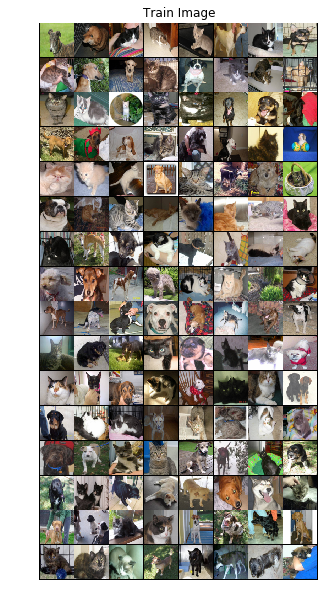

In [8]:
train_iter = iter(train_loader)
images, labels = train_iter.next()

imshow(images, "Train Image")

In [9]:
images.shape

torch.Size([128, 3, 96, 96])

## 15.2 Define Model

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 32, 5), # 32 * 92 * 92
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 32 * 46 * 46
            nn.Conv2d(32, 64, 5), # 64 * 42 * 42
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 64 * 21 * 21
            nn.Conv2d(64, 128, 4), # 128 * 18 * 18
            nn.ReLU(),
            nn.MaxPool2d(2,2) # 128 * 9 * 9
        )

        self.fc_layer = nn.Sequential(
            nn.Linear(128*9*9, 100),
            nn.ReLU(),
            nn.Linear(100, 2)              
        )
        
    def forward(self, x):
        out = self.conv_layer(x)
        out = out.view(-1, 128*9*9)
        out = self.fc_layer(out)
        
        return out
    
model = CNN().cuda()

In [11]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

## 15.3 Train Model

In [12]:
num_epochs = 5

In [13]:
for epoch in range(num_epochs):

    total_batch = len(train_data) // batch_size
    
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        
        X = batch_images.cuda()
        Y = batch_labels.cuda()

        pre = model(X)
        cost = loss(pre, Y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        if (i+1) % 50 == 0:
            print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, cost.item()))

Epoch [1/5], lter [50/156], Loss: 0.6985
Epoch [1/5], lter [100/156], Loss: 0.6932
Epoch [1/5], lter [150/156], Loss: 0.6962
Epoch [2/5], lter [50/156], Loss: 0.6924
Epoch [2/5], lter [100/156], Loss: 0.6905
Epoch [2/5], lter [150/156], Loss: 0.6964
Epoch [3/5], lter [50/156], Loss: 0.6892
Epoch [3/5], lter [100/156], Loss: 0.6911
Epoch [3/5], lter [150/156], Loss: 0.6941
Epoch [4/5], lter [50/156], Loss: 0.6895
Epoch [4/5], lter [100/156], Loss: 0.6926
Epoch [4/5], lter [150/156], Loss: 0.6807
Epoch [5/5], lter [50/156], Loss: 0.6871
Epoch [5/5], lter [100/156], Loss: 0.6786
Epoch [5/5], lter [150/156], Loss: 0.7034


## 15.4 Test Model

In [14]:
correct = 0
total = 0

for images, labels in test_loader:
    
    images = images.cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Accuracy of test images: %f %%' % (100 * float(correct) / total))

Accuracy of test images: 56.780000 %


In [15]:
torch.save(model, "sample3.pth")

C:\Users\slcf\Anaconda3\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
